# AI Classifier: Identifying Cats, Dogs & Pandas with PyTorch
### by KESAVAN S   
### 212224230121


In [1]:
import torch
torch.cuda.is_available()
# True

True

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce MX550


## Importing the necessary librarires


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms,models
from torchvision.utils import make_grid
import os
import matplotlib.pyplot as plt

## Modifying the input image so the image be in same size and normalized

In [4]:
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

### Extracting the dataset 

In [27]:
import zipfile as zip
files=zip.ZipFile("archive.zip")
files.extractall("CAT_DOG")
files.close()

### Importing the dataset

In [5]:
root='C:/Users/admin/Deep Learning Environment/workshop/CAT_DOG/archive/animals'

dataset = datasets.ImageFolder(root,transform=transform)

### Spliting the dataset into test and train

In [6]:
from torch.utils.data import random_split
train_sze=int(0.8*len(dataset))
test_sze=len(dataset)-train_sze


In [7]:
train_sze

2400

In [8]:
test_sze

600

In [9]:
train_data,test_data=random_split(dataset,[train_sze,test_sze])

In [10]:
train_loader=DataLoader(train_data,shuffle=True,batch_size=10)
test_loader=DataLoader(test_data,shuffle=True,batch_size=10)

In [11]:
class_names=test_data.dataset.classes
class_names

['cats', 'dogs', 'panda']

#### Defining the model for our CNN model

In [12]:
vgg=models.vgg16(weights=True)

C:\Users\admin\.conda\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
for param in vgg.parameters():
    param.requires_grad=False   #removes the gradient and descent and loss functions of the pre-defined the vgg mode;



In [14]:
torch.manual_seed(69)

In [15]:
vgg.classifier=nn.Sequential(
    nn.Linear(25088,1024),  #(input features,hiddenlayer 1)
    nn.ReLU(),             # only the positive values 
    nn.Dropout(0.4),       # making sure to prevent overfitting
    nn.Linear(1024,3)      #(hidden layer 1,output features)
)
    

In [16]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
for param in vgg.parameters():
    print(param.numel())  #making sure the last number and the number of outputs is same value

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
25690112
1024
3072
3


In [18]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(vgg.classifier.parameters(),lr=0.001)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#using cuda to make sure run on gpu so the time take to train the model is so much is reduced
vgg = vgg.to(device)

Using device: cuda


In [20]:
# Set time tracking
import time
start_time = time.time()

epochs = 3
max_trn_batch = 2400
max_tst_batch = 600

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train=X_train.to(device)
        y_train=y_train.to(device)
        if b == max_trn_batch:
            break
        b+=1

        # X_train, y_train = X_train.to(device), y_train.to(device)

        # Apply the model
        y_pred = vgg(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  # Print interim results
        if b%20==0:
          acc = trn_corr.item()*100 / ((b+1)*train_loader.batch_size)
          print(f'epoch: {i+1}  batch: {b+1} loss: {loss.item():.4f} accuracy: {acc:.2f}%')


    train_losses.append(loss)
    train_correct.append(trn_corr)

    # X_test, y_test = X_test.to(device), y_test.to(device)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test=X_test.to(device)
            y_test=y_test.to(device)
            
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = vgg(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch: 1  batch: 21 loss: 0.0180 accuracy: 74.76%
epoch: 1  batch: 41 loss: 0.8134 accuracy: 81.71%
epoch: 1  batch: 61 loss: 0.0580 accuracy: 86.07%
epoch: 1  batch: 81 loss: 0.0000 accuracy: 89.01%
epoch: 1  batch: 101 loss: 0.6675 accuracy: 89.80%
epoch: 1  batch: 121 loss: 1.9304 accuracy: 90.08%
epoch: 1  batch: 141 loss: 0.0001 accuracy: 90.85%
epoch: 1  batch: 161 loss: 0.0018 accuracy: 91.18%
epoch: 1  batch: 181 loss: 0.0000 accuracy: 91.44%
epoch: 1  batch: 201 loss: 1.4052 accuracy: 91.69%
epoch: 1  batch: 221 loss: 0.0000 accuracy: 92.13%
epoch: 1  batch: 241 loss: 4.3410 accuracy: 91.45%
epoch: 2  batch: 21 loss: 0.7391 accuracy: 91.43%
epoch: 2  batch: 41 loss: 0.0000 accuracy: 93.41%
epoch: 2  batch: 61 loss: 0.0098 accuracy: 93.93%
epoch: 2  batch: 81 loss: 0.8663 accuracy: 94.81%
epoch: 2  batch: 101 loss: 0.5954 accuracy: 94.65%
epoch: 2  batch: 121 loss: 0.0000 accuracy: 94.96%
epoch: 2  batch: 141 loss: 0.0000 accuracy: 95.18%
epoch: 2  batch: 161 loss: 1.1255 accur

In [21]:
print(test_correct)


[tensor(564, device='cuda:0'), tensor(565, device='cuda:0'), tensor(574, device='cuda:0')]


In [22]:
print(f'Test accuracy: {test_correct[-1].item()*100/len(test_data):.3f}%')

Test accuracy: 95.667%


In [23]:
#assigning the denormalization for the new input images so we can view the image clearly 
inv_normalize = transforms.Compose([
    transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225])
])


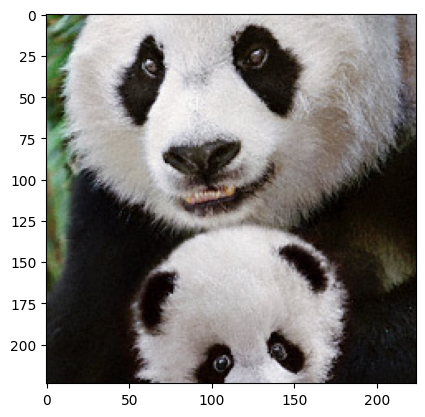

In [40]:
#getting a new image from a test data and gettin it fit in the normalization
image_index = 397
im = inv_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
plt.show()


In [51]:
vgg.eval() #sets the model to evaluation mode (turns off dropout and batch norm updates).
with torch.no_grad(): #disables gradient calculations for faster inference and less memory usage.
    new_pred = vgg(test_data[image_index][0].view(1,3,224,224).to(device)).argmax()
ans=class_names[new_pred.item()]
ans

'panda'

### Adding the confusion matirx to check the number of images and the classes it predicted

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [28]:

test_load_all = DataLoader(test_data, batch_size=20, shuffle=False)

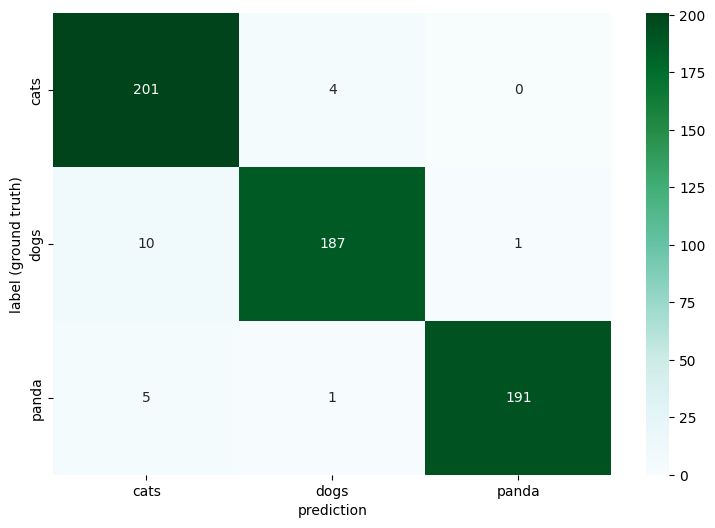

In [39]:
# 1. Initialize lists to store results
all_y_true = []
all_y_pred = []

# 2. Loop to collect all predictions (NO plotting here)
with torch.no_grad():
    for X_test, y_test in test_load_all:
        y_val = vgg(X_test.to(device))
        predicted = torch.max(y_val, 1)[1]
        
        all_y_true.extend(y_test.view(-1).cpu().numpy())
        all_y_pred.extend(predicted.view(-1).cpu().numpy())
        
# 3. Calculate and Plot (AFTER the loop)

# Calculate confusion matrix for the entire dataset
arr = confusion_matrix(all_y_true, all_y_pred)

# Define class names (assuming they are defined somewhere)
# class_names = ['cats', 'dogs']

df_cm = pd.DataFrame(arr, class_names, class_names)

# Plotting commands
plt.figure(figsize=(9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")

# THIS IS CRUCIAL
plt.show()

In [50]:
for i, name in enumerate(class_names):
    print(f"{name}: {counts[i].item()}")


cats: 205
dogs: 198
panda: 197


## saving the model

In [30]:
import pickle

In [31]:

filename='final.sav'
pickle.dump(vgg,open(filename,'wb'))

## Loading the model

In [33]:
loaded=pickle.load(open('final.sav','rb'))

### Testing again with the saved and loaded model

In [37]:
with torch.no_grad():
    new_pred = loaded(test_data[image_index][0].view(1,3,224,224).to(device)).argmax()
ans=class_names[new_pred.item()]
ans

'panda'